# MC Control with Epsilon Greedy Policy
Based on: https://github.com/dennybritz/reinforcement-learning/tree/master/MC

In [14]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 

matplotlib.style.use('ggplot')

In [36]:
%run blackjack.py plotting.py

In [37]:
env = BlackjackEnv()

In [56]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        nextActions = np.ones(nA, dtype = float) * epsilon / nA 
        bestAction = np.argmax(Q[observation])
        nextActions[bestAction] += (1.0 - epsilon) 
        return nextActions   
    return policy_fn

In [67]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        
        # Debugging code
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Make an episode
        episode = []
        state = env.reset()
        
        # Do 100 time steps
        for time in range(100):
            probs = policy(state)
            # Randomly choose from a list of probabilities 
            action = np.random.choice(np.arange(len(probs)), p=probs)
            nextState, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = nextState
        
        # Turn state-action pairs into tuples 
        saDict = set([(tuple(x[0]), x[1]) for x in episode]) 
        
        # Calculate the Q-value and count for each state-action pair
        for state, action in saDict: 
            saPair = (state, action)
    
            # Find the first occurrence 
            firstOccurrence = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            
            # Sum up all the rewards since the first occurrence 
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[firstOccurrence:])])
            
            # Calculate the average of G for state-action pair 
            returns_sum[saPair] += G
            returns_count[saPair] += 1.0 
            
            # Update the Q-function 
            Q[state][action] = returns_sum[saPair] / returns_count[saPair]     
        
    return Q, policy

In [68]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

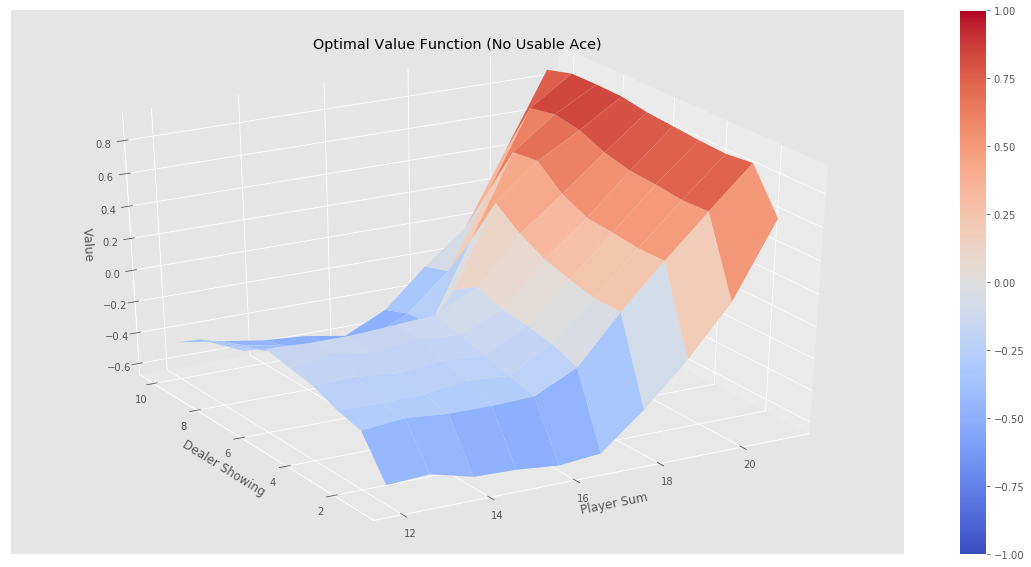

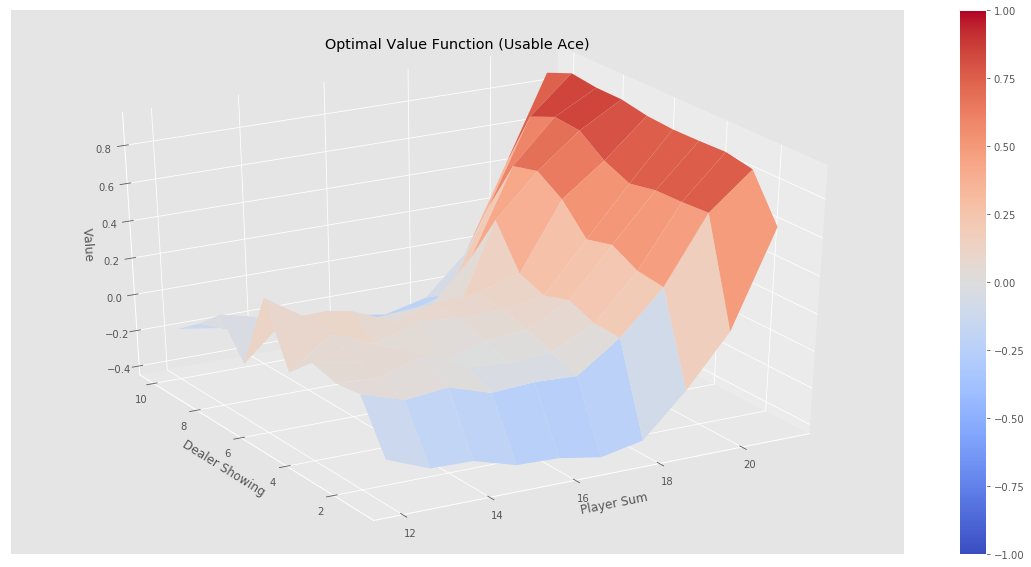

In [69]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")